## Face Detection

In [66]:
import os
import pandas as pd
import numpy as np
import PIL
import torch
import cv2
from tqdm import tqdm

from fastai.vision import Image

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.patches as patches

In [2]:
gpu = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
gpu

device(type='cuda', index=0)

In [3]:
def plot_detections(img, detections, with_keypoints=True):
    fig, ax = plt.subplots(1, figsize=(10, 10))
    ax.grid(False)
    ax.imshow(img)
    
    if isinstance(detections, torch.Tensor):
        detections = detections.cpu().numpy()

    if detections.ndim == 1:
        detections = np.expand_dims(detections, axis=0)

    print("Found %d faces" % detections.shape[0])
        
    for i in range(detections.shape[0]):
        ymin = detections[i, 0] * img.shape[0]
        xmin = detections[i, 1] * img.shape[1]
        ymax = detections[i, 2] * img.shape[0]
        xmax = detections[i, 3] * img.shape[1]

        rect = patches.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                 linewidth=1, edgecolor="r", facecolor="none", 
                                 alpha=detections[i, 16])
        ax.add_patch(rect)

        if with_keypoints:
            for k in range(6):
                kp_x = detections[i, 4 + k*2    ] * img.shape[1]
                kp_y = detections[i, 4 + k*2 + 1] * img.shape[0]
                circle = patches.Circle((kp_x, kp_y), radius=0.5, linewidth=1, 
                                        edgecolor="lightskyblue", facecolor="none", 
                                        alpha=detections[i, 16])
                ax.add_patch(circle)
        
    plt.show()

In [5]:
from blazeface import BlazeFace
net = BlazeFace().to(gpu)

In [6]:
net.load_weights("blazeface.pth")
net.load_anchors("anchors.npy")

In [7]:
# Optionally change the thresholds:
net.min_score_thresh = 0.75
net.min_suppression_threshold = 0.3

In [8]:
input_dir = "../data/dfdc_train_part_0"
video_path = os.path.join(input_dir, np.random.choice(os.listdir(input_dir)))
video_path

'../data/dfdc_train_part_0/ctooqkhtgp.mp4'

In [9]:
def read_frame(video_path):
    capture = cv2.VideoCapture(video_path)
    ret, frame = capture.read()
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    frame = cv2.resize(frame, (128, 128))
    capture.release()
    return frame

In [10]:
frame = read_frame(video_path)

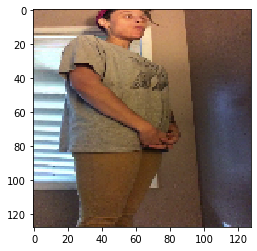

In [11]:
plt.imshow(frame)

In [12]:
detections = net.predict_on_image(frame)
detections

tensor([[-0.0252,  0.3510,  0.1467,  0.5229,  0.4547,  0.0244,  0.4923,  0.0285,
          0.5048,  0.0688,  0.4843,  0.1021,  0.3580,  0.0308,  0.4484,  0.0380,
          0.8612]], device='cuda:0')

How to interpret these 17 numbers:

- The first 4 numbers describe the bounding box corners:
  - ymin, xmin, ymax, xmax
  - These are normalized coordinates (between 0 and 1).
  - Note that y comes before x here!

- The next 12 numbers are the x,y-coordinates of the 6 facial landmark keypoints:
  - right_eye_x, right_eye_y
  - left_eye_x, left_eye_y
  - nose_x, nose_y
  - mouth_x, mouth_y
  - right_ear_x, right_ear_y
  - left_ear_x, left_ear_y
  
Tip: these labeled as seen from the perspective of the person, so their right is your left.
The final number is the confidence score that this detection really is a face.

Found 1 faces


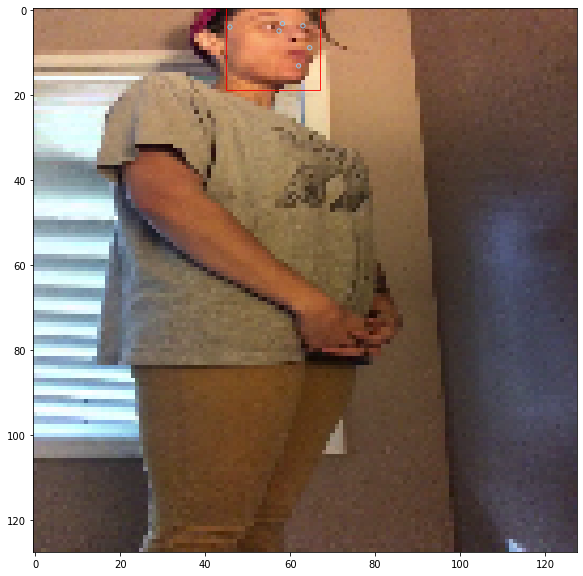

In [13]:
plot_detections(frame, detections)

### Crop the face out of it

In [14]:
ymin = max(0, int(detections[0, 0] * frame.shape[0])) # Don't try to crop less than 0
xmin = max(0, int(detections[0, 1] * frame.shape[1])) # Don't try to crop less than 0
ymax = int(detections[0, 2] * frame.shape[0])
xmax = int(detections[0, 3] * frame.shape[1])

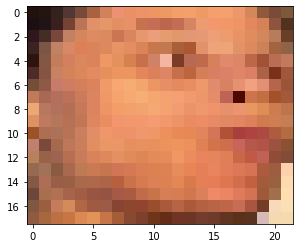

In [15]:
# Let's look at the face
face = frame[ymin:ymax, xmin:xmax]
plt.imshow(face)

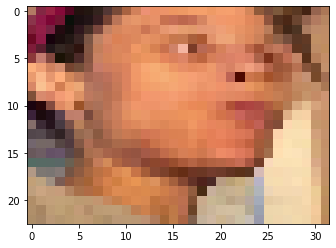

In [16]:
# Let's expand the bounding box a bit

increase = 5 # The amount we'd like to increase the box by
face = frame[max(0, ymin - increase):ymax + increase, max(0,xmin - increase):xmax + increase]
plt.imshow(face)

So this is working but it's an absymal image and seems way too small.

Let's try to come up with a way to fix this.

## Approach 1: Map coordinates back to original frame?

In [17]:
# Get the full frame
def read_full_frame(video_path):
    capture = cv2.VideoCapture(video_path)
    ret, frame = capture.read()
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    capture.release()
    return frame

In [18]:
full_frame = read_full_frame(video_path)
full_frame.shape

(1920, 1080, 3)

In [19]:
frame.shape

(128, 128, 3)

In [20]:
y_ratio = full_frame.shape[0] / frame.shape[0]
x_ratio = full_frame.shape[1] / frame.shape[1]

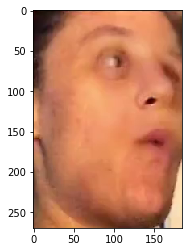

In [21]:
# Let's look at the face on the original image
y_min_original = int(y_ratio*ymin)
y_max_original = int(y_ratio*ymax)

x_min_original = int(x_ratio*xmin)
x_max_original = int(x_ratio*xmax)

face = full_frame[y_min_original:y_max_original, x_min_original:x_max_original]
plt.imshow(face)

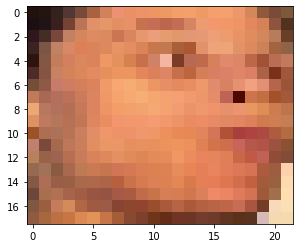

In [22]:
# Comparison to Original Approach
face = frame[ymin:ymax, xmin:xmax]
plt.imshow(face)

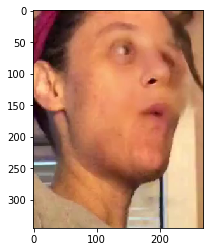

In [23]:
# This approach works when we expand the bounding box as well

# Let's expand the bounding box a bit

increase = 5 # The amount we'd like to increase the box by

y_min_original = max(0, int(y_ratio*(ymin - increase)))
y_max_original = int(y_ratio*(ymax + increase))

x_min_original = max(0, int(x_ratio*(xmin - increase)))
x_max_original = int(x_ratio*(xmax + increase))

face = full_frame[y_min_original:y_max_original, x_min_original:x_max_original]
plt.imshow(face)

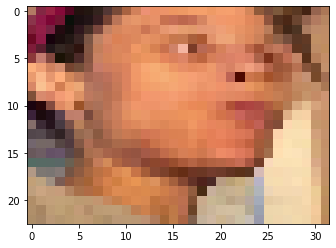

In [24]:
# Original
increase = 5 # The amount we'd like to increase the box by
face = frame[max(0, ymin - increase):ymax + increase, max(0, xmin - increase):xmax + increase]
plt.imshow(face)

## Find faces in all videos

In [25]:
input_dir = "../data/dfdc_train_part_0"
video_paths = [os.path.join(input_dir, file) for file in os.listdir(input_dir)]
# Only include .mp4 files
video_paths = list(filter(lambda x : x.endswith('.mp4'), video_paths))
len(video_paths), video_paths[:3]

(1334,
 ['../data/dfdc_train_part_0/gczieafvpe.mp4',
  '../data/dfdc_train_part_0/bemkbovwsz.mp4',
  '../data/dfdc_train_part_0/xlmduthjih.mp4'])

Let's try to find videos in which we can't seem to find a face.

In [26]:
unsure_paths = []
for path in tqdm(video_paths):
    frame = read_frame(path)
    detections = net.predict_on_image(frame)
    
    # If there are no detections keep track of it
    if len(detections) == 0:
        unsure_paths.append(path)
        
len(unsure_paths), unsure_paths[:5]

100%|██████████| 1334/1334 [01:13<00:00, 18.23it/s]


(352,
 ['../data/dfdc_train_part_0/omizcfnsic.mp4',
  '../data/dfdc_train_part_0/pjkgenkrgb.mp4',
  '../data/dfdc_train_part_0/yqahpmrcmp.mp4',
  '../data/dfdc_train_part_0/obttmvmtvi.mp4',
  '../data/dfdc_train_part_0/bhvnfaylpk.mp4'])

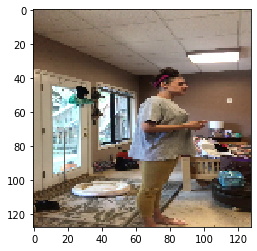

In [27]:
plt.imshow(read_frame(unsure_paths[0]))

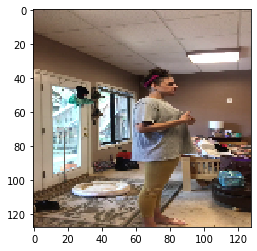

In [28]:
plt.imshow(read_frame(unsure_paths[1]))

../data/dfdc_train_part_0/yqahpmrcmp.mp4


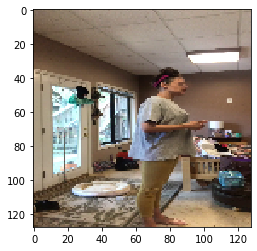

In [29]:
print(unsure_paths[2])
plt.imshow(read_frame(unsure_paths[2]))

Many of the ones we can't find are repetitions or are from the same angle.

It's also possible (since these are reptitions) that the process of making the deep fake is botching the face so badly that our face detector cannot even find the face!

Let's investigate this.

In [81]:
# Find the original file for this frame and see whether or not we can find the face in it
train = pd.read_json('../data/dfdc_train_part_0/metadata.json').T
original = train.loc[train.index == 'yqahpmrcmp.mp4']
original_path = original['original'].values[0]
original_path

'vpmyeepbep.mp4'

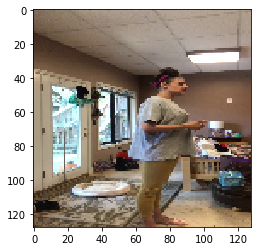

In [83]:
frame = read_frame('../data/dfdc_train_part_0/' + original_path)
plt.imshow(frame)

In [86]:
detections = net.predict_on_image(frame)
detections

tensor([], device='cuda:0', size=(0, 17))

In this case we still can't find the face :(

## Alternate Approach

Another approach is to use FaceNet to detect faces in images

In [31]:
from facenet_pytorch import MTCNN

In [32]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
detector = MTCNN(device=device, post_process=False)

In [56]:
frame = read_frame('../data/dfdc_train_part_0/ctooqkhtgp.mp4')
pilimg = PIL.Image.fromarray(frame)

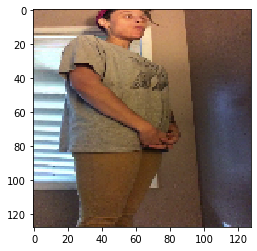

In [57]:
plt.imshow(frame)

In [59]:
face = detector(pilimg)

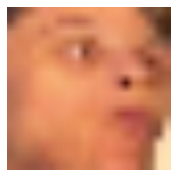

In [65]:
Image(face.type(torch.uint8)).show(figsize=(3, 3))

In [69]:
unsure_paths = []
for path in tqdm(video_paths):
    frame = read_frame(path)
    pilimg = PIL.Image.fromarray(frame)
    detections = detector(pilimg)
    
    # If there are no detections keep track of it
    if detections is None:
        unsure_paths.append(path)
        
len(unsure_paths), unsure_paths[:5]

100%|██████████| 1334/1334 [01:28<00:00, 15.08it/s]


(492,
 ['../data/dfdc_train_part_0/omizcfnsic.mp4',
  '../data/dfdc_train_part_0/eyyigsrqff.mp4',
  '../data/dfdc_train_part_0/pjkgenkrgb.mp4',
  '../data/dfdc_train_part_0/yqahpmrcmp.mp4',
  '../data/dfdc_train_part_0/zhopdnywsb.mp4'])